# Sentiment Analysis of Tech News Articles

In [22]:
import pandas as pd
import nltk
import math
nltk.download(["names",
     "stopwords",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
])

[nltk_data] Downloading package names to /Users/joey/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/joey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/joey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
train_set = pd.read_csv("training.csv", header=None)
devt_set = pd.read_csv("development.csv", header=None)
test_set = pd.read_csv("test.csv", header=None, encoding= 'unicode_escape')

In [24]:
print(len(train_set))
print(len(devt_set))
print(len(test_set))

2346
1500
774


In [25]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [26]:
sia.polarity_scores(train_set[1][164])

{'neg': 0.0, 'neu': 0.493, 'pos': 0.507, 'compound': 0.7351}

In [27]:
# Checks the sentiment of a single string of text, ranking it positive, negative, or neutral.
# Used for finding accuracy of our training data.
def check_sentiment_for_test(string_to_analyze):
    scores = sia.polarity_scores(string_to_analyze)
    neg_neu_pos = [scores['neg'],scores['neu'],scores['pos']]
    highest_score = neg_neu_pos.index(max(neg_neu_pos))
    return_values = ["negative", "neutral", "positive"]
    return return_values[highest_score]

# Checks the sentiment of a single string of text, giving it a numerical value.
# Used for finding numerical sentiment of our newspapers. 
def check_sentiment(string_to_analyze):
    scores = sia.polarity_scores(string_to_analyze)
    return scores["compound"]

In [28]:
check_sentiment_for_test(train_set[1][164])

'positive'

In [29]:
# Scoring each individual string from the corpus
train_list = []
for x in train_set[1]:
    train_list.append(check_sentiment_for_test(x))


In [30]:
# Here, we score the guesses of our sentiment analyzer.
# The score is based on the distance of the guesses, e.g.
# if the answer is "negative" but our system guesses "positive",
# the penalty is larger than, say, if the answer was "neutral"
# but our system guessed "positive".
total_score = len(train_list)
score_dict = {"negative":-0.5, "neutral":0, "positive":0.5}
for index, value in enumerate(train_list):
    total_score -= abs(score_dict[value] - score_dict[train_set[0][index]])

In [31]:
#Accuracy score
print(total_score/len(train_list))

0.8589087809036658


In [32]:
# Filters out the POS to only have nouns
pos_tags_to_keep = ["NN","NNP","NNS","NNPS"]
noun_list = []
for entry in train_set[1]:
    tokenized = nltk.word_tokenize(entry)
    tagged = nltk.pos_tag(tokenized)
    new_phrase = ""
    for word in tagged:
        if word[1] in pos_tags_to_keep:
            new_phrase += word[0] + " "
    noun_list.append(new_phrase)

#Get sentiment for train set with only nouns:
train_list_noun = []
for x in noun_list:
    train_list_noun.append(check_sentiment_for_test(x))
total_score = len(train_list_noun)
score_dict = {"negative":-0.5, "neutral":0, "positive":0.5}
for index, value in enumerate(train_list_noun):
    
    total_score -= abs(score_dict[value] - score_dict[train_set[0][index]])

#Accuracy score with only nouns
print(total_score/len(train_list_noun))

0.8388746803069054


In [33]:
# Filters out the POS to only have adjectives
pos_tags_to_keep = ["JJS","JJR","JJ"]
adj_list = []
for entry in train_set[1]:
    tokenized = nltk.word_tokenize(entry)
    tagged = nltk.pos_tag(tokenized)
    new_phrase = ""
    for word in tagged:
        if word[1] in pos_tags_to_keep:
            new_phrase += word[0] + " "
    adj_list.append(new_phrase)

#Get sentiment for train set with only adjectives:
train_list_adj = []
for x in adj_list:
    train_list_adj.append(check_sentiment_for_test(x))
total_score = len(train_list_adj)
score_dict = {"negative":-0.5, "neutral":0, "positive":0.5}
for index, value in enumerate(train_list_adj):
    total_score -= abs(score_dict[value] - score_dict[train_set[0][index]])

#Accuracy score with only adjectives
print(total_score/len(train_list_adj))

0.7664109121909634


In [34]:
# Filters out the POS to only have adjectives AND nouns
pos_tags_to_keep = ["JJS","JJR","JJ","NN","NNP","NNS","NNPS"]
adj_noun_list = []
for entry in train_set[1]:
    tokenized = nltk.word_tokenize(entry)
    tagged = nltk.pos_tag(tokenized)
    new_phrase = ""
    for word in tagged:
        if word[1] in pos_tags_to_keep:
            new_phrase += word[0] + " "
    adj_noun_list.append(new_phrase)

#Get sentiment for train set with only adjectives:
train_list_adj_noun = []
for x in adj_noun_list:
    train_list_adj_noun.append(check_sentiment_for_test(x))
total_score = len(train_list_adj_noun)
score_dict = {"negative":-0.5, "neutral":0, "positive":0.5}
for index, value in enumerate(train_list_adj_noun):
    total_score -= abs(score_dict[value] - score_dict[train_set[0][index]])

#Accuracy score with only adjectives and nouns
print(total_score/len(train_list_adj_noun))

0.8478260869565217


In [35]:
#percent change of open and close of stock price
#stock_changes =[((357.59-349.3)/349.3),0.0,0.0,((354.9-356.76)/356.76),((352.65-352.62)/352.62),((358.49-355.02)/355.02),((365.97-363.24)/363.24),((352.65-352.62)/352.62),0.0,0.0,0.0,((372.45-368.64)/368.64),((371.78-372)/372),((373.12-371.55)/371.55),((378.8-376.39)/376.39),((373.12-371.55)/371.55),((381.95-377.35)/377.35),0.0,0.0,((380.69-380.89)/380.89),((384.79-382.08)/382.08),((380.69-380.89)/380.89),((380.62-385)/385),((387.09-384.37)/384.37),((386.49-388.04)/388.04),0.0,0.0,((382.84-384.81)/384.81),((382.95-378.13)/378.13),((379.39-382.5)/382.5),((384.92-380.04)/380.04),0.0,0.0,((388.04-385.03)/385.03)]
#stock_changes

In [36]:
#finds sentiment of each article in a given outlet
def article_sentiment(filename, filterPOS):
    list_sentiment=[]
    with open(filename) as file:
        data = file.read()
        articles = data.split("--")
        for article in articles:
            tokenized = nltk.word_tokenize(article)
            tagged = nltk.pos_tag(tokenized)
            if filterPOS:
                new_phrase = ""
                for word in tagged:
                    if filterPOS:
                        if word[1] in pos_tags_to_keep:
                            new_phrase += word[0] + " "
                list_sentiment.append(check_sentiment(new_phrase))
            else:
                list_sentiment.append(check_sentiment(article))
        return list_sentiment


In [38]:
#We will first try without any POS filtering
wsj_sentiment_raw = article_sentiment("WSJ.txt",False)
ap_sentiment_raw = article_sentiment("AP.txt",False)
nyt1_sentiment_raw = article_sentiment("NYT1.txt",False)
nyt2_sentiment_raw = article_sentiment("NYT2.txt",False)

#gets the average sentiment of the two articles
daily_score_raw=[]
summage=0
for i in range(len(wsj_sentiment_raw)):
    if i==7:
        daily_score_raw.append(0)
        summage+=(wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4
    elif i%7==1 or i%7==2:
        daily_score_raw.append(0)
        summage+=(wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4
    elif i%7==3:
        daily_score_raw.append(((wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4+summage)/3) 
        summage=0
    else:
        daily_score_raw.append((wsj_sentiment_raw[i]+ap_sentiment_raw[i]+nyt1_sentiment_raw[i]+nyt2_sentiment_raw[i])/4)

    
daily_score_raw

[0.9858750000000001,
 0,
 0,
 0.673925,
 0.678025,
 0.9472750000000001,
 0.54535,
 0,
 0,
 0,
 0.738925,
 0.062775,
 -0.036900000000000016,
 0.6877,
 0.8451749999999999,
 0,
 0,
 0.9882499999999999,
 -0.039299999999999974,
 0.133175,
 0.4648749999999999,
 0.488625,
 0,
 0,
 0.6467166666666666,
 0.49055000000000004,
 0.95485,
 0.4716,
 0.9968,
 0,
 0,
 0.7926333333333333]

In [39]:
#Now we try by filtering only nouns

pos_tags_to_keep = ["NN","NNP","NNS","NNPS"]



wsj_sentiment_noun = article_sentiment("WSJ.txt",True)
ap_sentiment_noun = article_sentiment("AP.txt",True)
nyt1_sentiment_noun = article_sentiment("NYT1.txt",True)
nyt2_sentiment_noun = article_sentiment("NYT2.txt",True)
#gets the average sentiment of the two articles
daily_score_noun=[]
summage=0
for i in range(len(wsj_sentiment_noun)):
    if i==7:
        daily_score_noun.append(0)
        summage+=(wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4
    elif i%7==1 or i%7==2:
        daily_score_noun.append(0)
        summage+=(wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4
    elif i%7==3:
        daily_score_noun.append(((wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4+summage)/3) 
        summage=0
    else:
        daily_score_noun.append((wsj_sentiment_noun[i]+ap_sentiment_noun[i]+nyt1_sentiment_noun[i]+nyt2_sentiment_noun[i])/4)

    
daily_score_noun



[0.7844249999999999,
 0,
 0,
 0.1408083333333333,
 0.781525,
 0.7116750000000001,
 0.298675,
 0,
 0,
 0,
 0.8317833333333334,
 -0.12302500000000002,
 0.0597,
 0.0005499999999999672,
 0.44270000000000004,
 0,
 0,
 0.909525,
 -0.343625,
 0.24475,
 -0.16752500000000003,
 0.08495,
 0,
 0,
 0.33294166666666664,
 0.728025,
 0.9399500000000001,
 0.73335,
 0.913775,
 0,
 0,
 0.5904666666666666]

In [40]:
#Now we try by filtering only adjectives

pos_tags_to_keep = ["JJS","JJR","JJ"]



wsj_sentiment_adj = article_sentiment("WSJ.txt",True)
ap_sentiment_adj = article_sentiment("AP.txt",True)
nyt1_sentiment_adj = article_sentiment("NYT1.txt",True)
nyt2_sentiment_adj = article_sentiment("NYT2.txt",True)
#gets the average sentiment of the two articles 
daily_score_adj=[]
summage=0
for i in range(len(wsj_sentiment_adj)):
    if i==7:
        daily_score_adj.append(0)
        summage+=(wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4
    elif i%7==1 or i%7==2:
        daily_score_adj.append(0)
        summage+=(wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4
    elif i%7==3:
        daily_score_adj.append(((wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4+summage)/3) 
        summage=0
    else:
        daily_score_adj.append((wsj_sentiment_adj[i]+ap_sentiment_adj[i]+nyt1_sentiment_adj[i]+nyt2_sentiment_adj[i])/4)

    
daily_score_adj


[0.571025,
 0,
 0,
 0.63205,
 0.691475,
 0.433725,
 0.359325,
 0,
 0,
 0,
 0.6368,
 0.03132500000000002,
 0.42014999999999997,
 0.553575,
 0.7725,
 0,
 0,
 0.8500249999999999,
 0.41767499999999996,
 0.1901,
 0.5012,
 0.40812499999999996,
 0,
 0,
 0.7754416666666667,
 0.3249,
 0.772375,
 0.16630000000000003,
 0.9561499999999999,
 0,
 0,
 0.6085583333333333]

In [41]:
#Now we try by filtering adjectives and nouns

pos_tags_to_keep = ["JJS","JJR","JJ","NN","NNP","NNS","NNPS"]
#finds sentiment of each article in a given outlet



wsj_sentiment_adj_noun = article_sentiment("WSJ.txt",True)
ap_sentiment_adj_noun = article_sentiment("AP.txt",True)
nyt1_sentiment_adj_noun = article_sentiment("NYT1.txt",True)
nyt2_sentiment_adj_noun = article_sentiment("NYT2.txt",True)

#gets the average of the two articles based on score_dict
daily_score_adj_noun=[]
summage=0
for i in range(len(wsj_sentiment_adj_noun)):
    #good friday
    if i==7:
        daily_score_adj_noun.append(0)
        summage+=(wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4
    #sat,sunday
    elif i%7==1 or i%7==2:
        daily_score_adj_noun.append(0)
        summage+=(wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4
    #monday, average them
    elif i%7==3:
        daily_score_adj_noun.append(((wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4+summage)/3) 
        summage=0
    else:
        daily_score_adj_noun.append((wsj_sentiment_adj_noun[i]+ap_sentiment_adj_noun[i]+nyt1_sentiment_adj_noun[i]+nyt2_sentiment_adj_noun[i])/4)
daily_score_adj_noun


[0.9574749999999999,
 0,
 0,
 0.39302499999999996,
 0.8938,
 0.720075,
 0.5348,
 0,
 0,
 0,
 0.983275,
 -0.003975000000000006,
 0.39710000000000006,
 0.010399999999999993,
 0.7648750000000001,
 0,
 0,
 0.9677000000000001,
 -0.19605,
 0.28825,
 0.312025,
 0.2615,
 0,
 0,
 0.6257583333333333,
 0.76785,
 0.9704250000000001,
 0.4333,
 0.988175,
 0,
 0,
 0.6525083333333334]

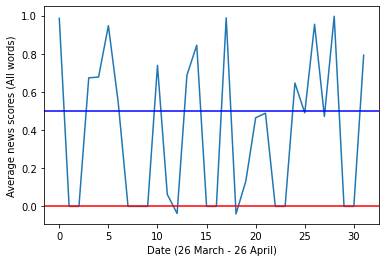

In [42]:
import matplotlib.pyplot as plt
plt.plot(daily_score_raw)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (All words)")
plt.show()

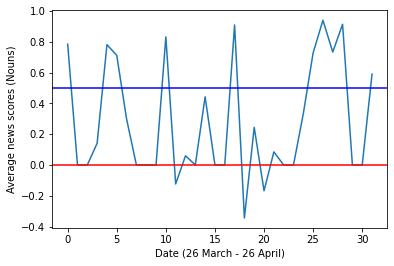

In [43]:
plt.plot(daily_score_noun)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (Nouns)")
plt.show()

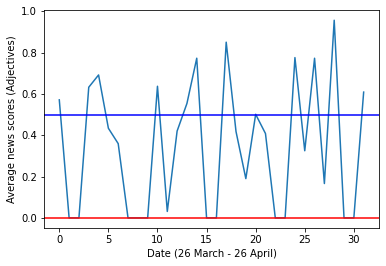

In [44]:
plt.plot(daily_score_adj)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (Adjectives)")
plt.show()

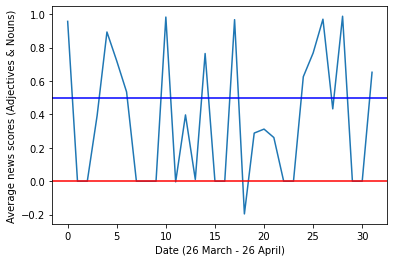

In [45]:
plt.plot(daily_score_adj_noun)
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=0.5, color='b', linestyle='-')
plt.xlabel("Date (26 March - 26 April)")
plt.ylabel("Average news scores (Adjectives & Nouns)")
plt.show()

[2.2006916459458656, 0.0, 0.0, -0.7522581727676942, -0.6339814032121724, 1.656032893804064, 2.086529610309916, 0.0, 0.0, 0.0, 1.7706369374538788, -0.17988991810981766, 0.3604282102318661, 1.5222984562607222, 0.8315733896515252, 0.0, 0.0, -0.32988611074747765, 1.0769917780871636, -1.0837079965695615, 1.6998581262151151, -0.15500271254746079, 0.0, 0.0, -0.9443970089782489, -1.0134782154424813, 1.0528815706143153, -0.929625277451365, 1.4576029942803, 0.0, 0.0, 0.8105580380338783, -0.3504793320276295, -0.7913520223440577, -0.30759605859965766, -1.4381340863926368, 0.0, 0.0, -0.40059425903326545]


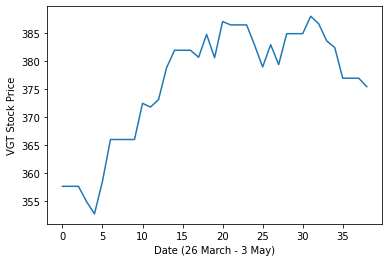

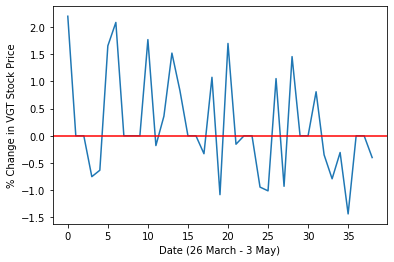

In [46]:
import numpy as np
stock_prices = []
stock = open("VGT Price.txt")
counter = 0
for line in stock:
    if counter == 0:
        counter += 1
    elif counter < 40:
        price = line.split(" ")
        stock_prices.append(float(price[1].strip("\n")))
        counter += 1
    else:
        break

#print(stock_prices)                            
delta_stock_prices = [(357.59-349.89)/349.89*100]
for i in range(len(stock_prices) - 1):
    delta_stock_prices.append((stock_prices[i+1] - stock_prices[i]) / stock_prices[i] * 100)
print(delta_stock_prices)

plt.plot(stock_prices)
plt.xlabel("Date (26 March - 3 May)")
plt.ylabel("VGT Stock Price")
plt.show()

plt.plot(delta_stock_prices)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Date (26 March - 3 May)")
plt.ylabel("% Change in VGT Stock Price")
plt.show()
    

In [47]:
#correlation

y = np.array(stock_prices[:32])
x_all = np.array(daily_score_raw)
x_adj_noun = np.array(daily_score_adj_noun)
x_adj = np.array(daily_score_adj)
x_noun = np.array(daily_score_noun)

r_all = np.corrcoef(x_all, y)
r_adj_noun = np.corrcoef(x_adj_noun, y)
r_adj = np.corrcoef(x_adj, y)
r_noun = np.corrcoef(x_noun, y)
print("Coefficient of correlation with all words:  ", r_all[0,1])
print("Coefficient of correlation using nouns & adjectives: ", r_adj_noun[0,1])
print("Coefficient of correlation using adjectives: ", r_adj[0,1])
print("Coefficient of correlation using nouns: ", r_noun[0,1])

Coefficient of correlation with all words:   -0.054871495597268206
Coefficient of correlation using nouns & adjectives:  -0.09353152656591482
Coefficient of correlation using adjectives:  0.06640464985537803
Coefficient of correlation using nouns:  -0.09922574037526988
